# Code summary
This notebook will guide a very simple example of how to do some evaluation on a classifier (aka "jet-tagger") with pytorch using th ATLAS top-tagging dataset at https://opendata.cern.ch/record/80030.

We will assume you are familiar and ran the train.ipynb and previous notebooks already

In adititon to the previous single nominal testing dataset, we will also download some of the other variation datasets and check the performance of the tagger with respect to those.

Much of the code below is more elaborate then is needed for a simple tutorial, but this is so that it can provide a useful copy-and-paste template for your own projects.

## Acessing the data

Exactly as before, lets download an input file to inspect

In [1]:
import sys,os
if not(os.path.isfile("test_nominal_000.h5")):
    if sys.platform=="darwin": #MAC OSX
        !curl https://opendata.cern.ch/record/80030/files/assets/atlas/datascience/CERN-EP-2024-159/test_nominal_000.h5.gz --output test_nominal_000.h5.gz
    elif sys.platform == "linux" or sys.platform == "linux2":
        !wget https://opendata.cern.ch/record/80030/files/assets/atlas/datascience/CERN-EP-2024-159/test_nominal_000.h5.gz
    !gunzip -f test_nominal_000.h5.gz

And let's import some packages we will need

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, ConcatDataset
from torchinfo import summary

from sklearn import metrics
import matplotlib.pyplot as plt
import h5py
import numpy as np

# Redefining the pytorch model and dataloader

Okay now we will do some copy and paste from the previous notebook on the pytorch dataloader and the neural net model. Outside of jupyter notebook I would probably put these in a seperate .py file and load it in both scripts, as to not have duplicates.

First the `Dataset` will be identical to before, but we will define the pre-processing fucntion right away. Also we'll add an extra option to return the jet pt, which wasn't a training feature before

In [3]:
class ATLASH5HighLevelDataset(torch.utils.data.Dataset):
    def transform(self,data,transform=True):
        if transform:
            #Calculate some metrics from subsample of total
            vals=[]
            Njets=np.max([1000,data.len()])
            for jet in range(Njets): vals.append(data[jet])
            maxval=np.max(vals)
            minval=np.min(vals)
            return (data-minval)/(maxval-minval)
        else:
            return data

    def __init__(self, file_path, transform=True, return_pt=False):
        super(ATLASH5HighLevelDataset, self).__init__()
        h5_file = h5py.File(file_path , 'r')
        self.data=torch.tensor([])
    
        self.C2=self.transform(h5_file['fjet_C2'],transform=transform)
        self.D2=self.transform(h5_file['fjet_D2'],transform=transform)
        self.ECF1=self.transform(h5_file['fjet_ECF1'],transform=transform)
        self.ECF2=self.transform(h5_file['fjet_ECF2'],transform=transform)
        self.ECF3=self.transform(h5_file['fjet_ECF3'],transform=transform)
        self.L2=self.transform(h5_file['fjet_L2'],transform=transform)
        self.L3=self.transform(h5_file['fjet_L3'],transform=transform)
        self.Qw=self.transform(h5_file['fjet_Qw'],transform=transform)
        self.Split12=self.transform(h5_file['fjet_Split12'],transform=transform)
        self.Split23=self.transform(h5_file['fjet_Split23'],transform=transform)
        self.Tau1_wta=self.transform(h5_file['fjet_Tau1_wta'],transform=transform)
        self.Tau2_wta=self.transform(h5_file['fjet_Tau2_wta'],transform=transform)
        self.Tau3_wta=self.transform(h5_file['fjet_Tau3_wta'],transform=transform)
        self.Tau4_wta=self.transform(h5_file['fjet_Tau4_wta'],transform=transform)
        self.ThrustMaj=self.transform(h5_file['fjet_ThrustMaj'],transform=transform)
        self.m=self.transform(h5_file['fjet_m'],transform=transform)
    
        self.pt = h5_file['fjet_pt']
        self.labels = h5_file['labels']
        if "training_weights" in h5_file:
            self.hasWeights=True
            self.weights = h5_file['training_weights']
        else:
            self.hasWeights=False
    
        self.return_pt = return_pt
    
    def __getitem__(self, index):
        self.data=torch.tensor([self.D2[index],self.C2[index],self.ECF1[index],self.ECF2[index],self.ECF3[index],self.L2[index],self.L3[index],self.Qw[index],self.Split12[index],self.Split23[index],self.Tau1_wta[index],self.Tau2_wta[index],self.Tau3_wta[index],self.Tau4_wta[index],self.ThrustMaj[index],self.m[index]])
    
        #new extra return appended to usual inputs
        if self.return_pt:
            self.data=self.data,torch.tensor([self.pt[index]])
    
        if self.hasWeights:
            return self.data,torch.tensor(self.labels[index],dtype=torch.int64),torch.tensor(self.weights[index])
        else:
            return self.data,torch.tensor(self.labels[index],dtype=torch.int64),torch.tensor(1)
    
    def __len__(self):
        return len(self.labels)

And now let's get the single testing file result via a `DataLoader` again, since we did all the hard work there already

In [4]:
#Load the dataset into an object
testing_data=ATLASH5HighLevelDataset("./test_nominal_000.h5",transform=True, return_pt=True)

#Then give it to the dataloader, here we say to shuffle the data and also feed us batches of 1 jets every time we loop
test_dataloader = DataLoader(testing_data, batch_size=1, shuffle=True)

Similarly we'll use the exact same model class

In [5]:
class DNNetwork(nn.Module):
    def __init__(self,Ninputs,useConstituents=False):
        super().__init__()
        self.useConstituents=useConstituents
    
        if self.useConstituents: self.flatten = nn.Flatten()
        #self.norm=nn.BatchNorm1d(Ninputs)
        self.fc1= nn.Linear(Ninputs, 512)
        self.act1=nn.ReLU()
        self.fc2= nn.Linear(512, 512)
        self.act2=nn.ReLU()
        self.fc3= nn.Linear(512, 512)
        self.act3=nn.ReLU()
        self.fc4= nn.Linear(512, 2)
    
    def forward(self, x):
        if self.useConstituents: x = self.flatten(x)
        #x=self.norm(x)
        f1=self.act1(self.fc1(x))
        f2=self.act2(self.fc2(f1))
        f3=self.act3(self.fc3(f2))
        logits = self.fc4(f3)
        return logits

Now we well define the model object again but load all the weight information from our previous training

In [6]:
Ndim = len(test_dataloader.dataset[0][0][0])
device = "cpu"
model = DNNetwork(Ndim).to(device)
model.load_state_dict(torch.load("model.pth"))
print(model)

DNNetwork(
  (fc1): Linear(in_features=16, out_features=512, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (act3): ReLU()
  (fc4): Linear(in_features=512, out_features=2, bias=True)
)


## Evaluation of tagger performance

Now to the new part. Let's evaluate some usual machine-learning classification metrics on our network performance

First let's define a function to return the relevant infomation for the whole dataset in a numpy array. This follows the usual pytorch evaluation of looping over the batches and calculating the model prediction. Here we also will apply the sigmoid term though which isn't part of the network final layer in our example

In [7]:
#Load information into numpy arrays
def load_score(dataloader):
    ys=np.array([])
    preds_raw=np.empty((0,2))
    weights=np.array([])
    pts=np.array([])
    with torch.no_grad(): #Always good habit to include this outside of training
        for (X, pt), y, w in dataloader: #Note we are returning the pt here too as an extra variable
            
            #Get prediction
            pred=model(X)
            pred=torch.sigmoid(pred)

            #append info
            preds_raw=np.concatenate([preds_raw,pred.numpy()])
            ys=np.concatenate([ys,y.numpy().flatten()])
            pts=np.concatenate([pts,pt.numpy().flatten()])
            weights=np.concatenate([weights,pt.numpy().flatten()])
    return preds_raw,ys,weights,pts

Okay now let's get the values

In [8]:
preds_raw,ys,weights,pts=load_score(test_dataloader)

Now since we have defined our problem as having 2 output notes, we'll define a decision rule as the log ratio of probabilities. This condenses the problem back to a 1 dimensional one.
This is a common approach in various machine learning and statistics literature, but shouldn't be treated as a rule

In [9]:
#Decision rule
def decision_rule(raw_preds):
    #return raw_preds[:,0]/raw_preds[:,1]
    #return np.log(raw_preds[:,0]/raw_preds[:,1])
    return np.log(raw_preds[:,0])/np.log(raw_preds[:,1])
preds=decision_rule(preds_raw)

Let's make a quick plot of it for the signal and background

/Users/les/venv/CometaTutorial/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/Users/les/venv/CometaTutorial/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.


JSD=10202.979106757513


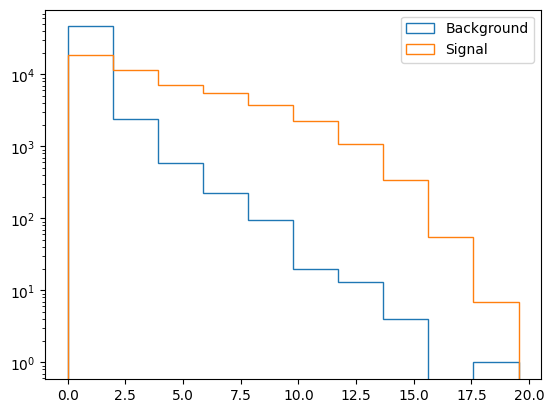

In [10]:
xmin=np.min(preds)
xmax=np.max(preds)
bkgprob,*_=plt.hist(preds[ys==0],bins=10,histtype="step",range=[xmin,xmax],label="Background")
sigprob,*_=plt.hist(preds[ys==1],bins=10,histtype="step",range=[xmin,xmax],label="Signal")
plt.legend()
plt.yscale("log")

#Calculate JSD
Mprob=0.5*(sigprob+bkgprob)
JSD=0.5*np.nansum(sigprob*np.log(sigprob/Mprob))+0.5*np.nansum(bkgprob*np.log(bkgprob/Mprob)) #Jensen Shannon Divergence
print(f"JSD={JSD}")

So with a decision rule we can make everyone's favorite plot: the ROC curve. This is pretty easy via the `scikit-learn` package. We'll use the ATLAS convention of showing the signal efficiency vs the background rejection (aka one over the background efficiency)

/Users/les/venv/CometaTutorial/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


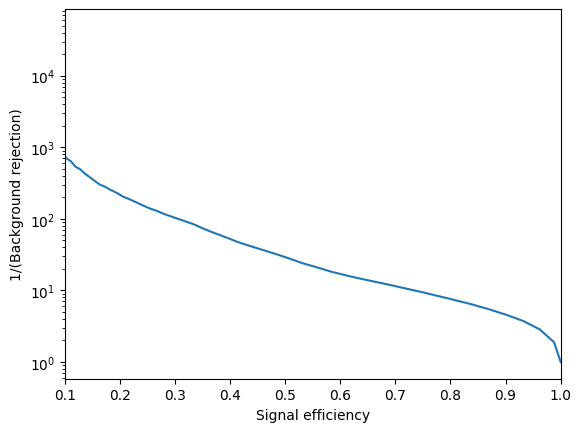

In [11]:
xmin=np.min(preds)
xmax=np.max(preds)
sigs=preds[ys==1]
bkgs=preds[ys==0]

tmp_tpr=[]
tmp_fpr=[]
tmp_thr=[]
for cut in np.linspace(xmin,xmax,100):
    tmp_thr.append(cut)
    tmp_tpr.append(len(sigs[sigs>cut])/len(sigs))
    tmp_fpr.append(len(bkgs[bkgs>cut])/len(bkgs))
  
fig, ax = plt.subplots()
plt.plot(tmp_tpr,1/np.array(tmp_fpr))
ax.set_yscale('log')
ax.set_xlim([0.1, 1.0])
ax.set_xlabel("Signal efficiency")
ax.set_ylabel("1/(Background rejection)")
fig.savefig("ROC.pdf") 

/Users/les/venv/CometaTutorial/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


[2.05449598e+01 1.95449598e+01 1.79815293e+01 ... 1.13581606e-02
 1.11540663e-02 8.47503891e-04]


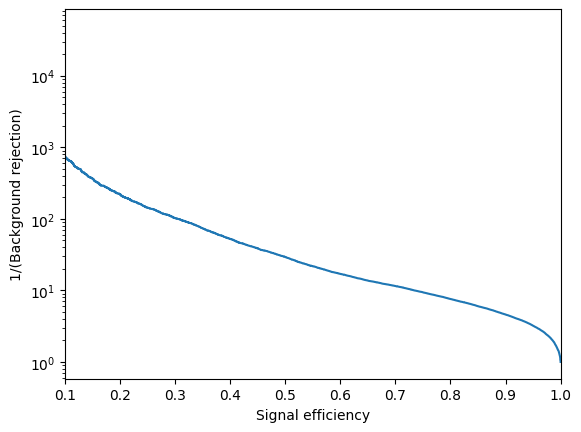

In [12]:
#make ROC curve
fpr, tpr, thresholds = metrics.roc_curve(ys, preds, sample_weight=weights) # return false and true positive rates, and the probed decsion rule threhsolds
fpr, tpr, thresholds = metrics.roc_curve(ys, preds) # return false and true positive rates, and the probed decsion rule threhsolds

fig, ax = plt.subplots()
ax.plot(tpr,1/fpr)
ax.set_yscale('log')
ax.set_xlim([0.1, 1.0])
ax.set_xlabel("Signal efficiency")
ax.set_ylabel("1/(Background rejection)")
fig.savefig("ROC.pdf") 
print(thresholds)

We can also make a confusion matrix based on the highest node prediction (or some other decision rule). This is less useful for binary classification, but more interesting for multi-classification problems.

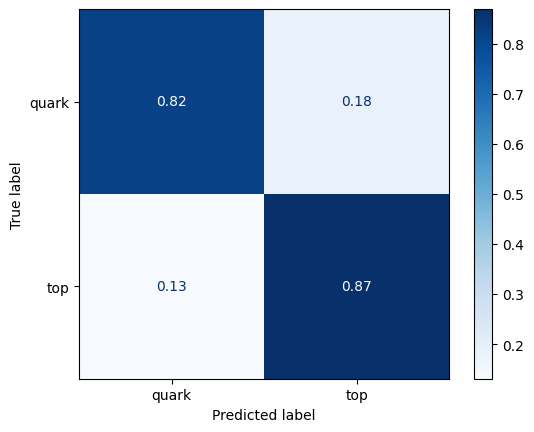

In [13]:
#make confusion matrix
disp=metrics.ConfusionMatrixDisplay.from_predictions(ys, np.argmax(preds_raw,axis=1),normalize="true",cmap="Blues",display_labels=["quark","top"])
plt.savefig("confusion.pdf") 

## ATLAS Evaluation of tagger performance

Besides some usual machine-learning metrics, like the ROC curve, let's perform some evaluation metrics as usually shown in ATLAS performance plots. In particular the common one is the background rejection as a function of jet pt at a fixed signal working point of 50\%

So first let's define a cut threshold so the signal efficiency is at a fixed perfentage (aka a working point)

In [14]:
#Find 50% working point
index_of_wp=np.argmax(tpr>0.5)
wp50=thresholds[index_of_wp]
rej50=fpr[index_of_wp]
print(f"50% decision threshold of {wp50} gives rejection of {1/rej50:.1f}")

50% decision threshold of 2.8550854733329474 gives rejection of 29.4


So that was simple, but actually is inclusive on jet-pt. Our input signal jet pt spectrum wasn't completely flat so the perfromance of the tagger isn't flat in this variable. We can pseudo-flatten it out by defining a seperate working point across pt-bins

In [15]:
#Pt bins we'll look at
Nbins=10
bins=np.linspace(0.3e6,1.5e6,Nbins+1,endpoint=True)

#Loop over the bins
wp50_values=[]

for binx in range(Nbins):
    #Select only the jets in the pt bin
    mask = (pts>bins[binx]) & (pts<bins[binx+1])
        
    #Get the true positive rate from ROC (can do other ways if you want)
    fpr, tpr, thresholds = metrics.roc_curve(ys[mask], preds[mask], sample_weight=weights[mask])
    
    #Get the threshold
    index_of_wp=np.argmax(tpr>0.5)
    wp50=thresholds[index_of_wp]
    rej50=fpr[index_of_wp]
    print(f"For pt bin {binx} the 50% decision threshold of {wp50} gives rejection of {1/rej50:.1f}")
    wp50_values.append(wp50)


For pt bin 0 the 50% decision threshold of 4.134328285449059 gives rejection of 72.4
For pt bin 1 the 50% decision threshold of 3.9051287990722408 gives rejection of 58.5
For pt bin 2 the 50% decision threshold of 3.636289162779513 gives rejection of 51.1
For pt bin 3 the 50% decision threshold of 3.4306070744163373 gives rejection of 52.8
For pt bin 4 the 50% decision threshold of 3.2397933941160684 gives rejection of 36.1
For pt bin 5 the 50% decision threshold of 3.110688463522181 gives rejection of 34.3
For pt bin 6 the 50% decision threshold of 3.1883120862019885 gives rejection of 42.5
For pt bin 7 the 50% decision threshold of 3.120145557506765 gives rejection of 25.3
For pt bin 8 the 50% decision threshold of 3.1616175163717957 gives rejection of 42.6
For pt bin 9 the 50% decision threshold of 3.373930522405876 gives rejection of 39.1


Now as usual let's make a quick little script we'll call multiple times to calculate the rejection of an input dataset. It's just the ratio of all jets to those passing the requirement, across the pt bins

In [16]:
# make rejection plot at working point
def rejection_hist(ys,preds,pts,bins,wp):
    #Let's just look at background labeled samples
    bkg_indices=np.argwhere(ys==0)
    bkg_pts=pts[bkg_indices]
    bkg_preds=preds[bkg_indices]
    
    #Arrays to fille
    N_accepted=np.zeros(len(bins)-1)
    N_all=np.zeros(len(bins)-1)
    for ii in range(len(bkg_indices)):
        
        #find bin
        binx=np.argmax(bins>bkg_pts[ii])
        if binx>len(N_all)-1: continue

        #Fill the arrays
        N_all[binx]+=1
        if bkg_preds[ii]>wp[binx]: N_accepted[binx]+=1
            
    return np.nan_to_num(N_all/N_accepted)

And let's plot it

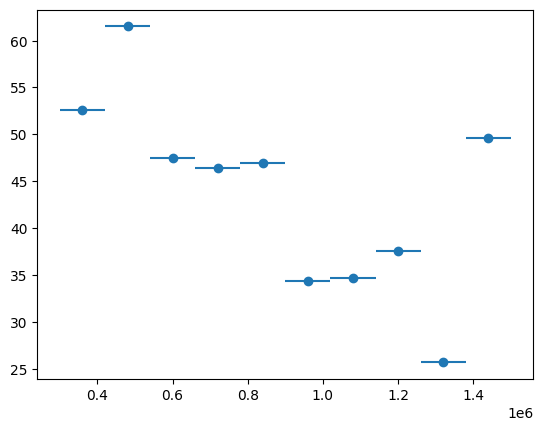

In [17]:
#make the hist
nom_hist=rejection_hist(ys,preds,pts,bins,wp50_values)

#plot it
fig, ax = plt.subplots()
ax.errorbar((bins[1:]+bins[:-1])/2, nom_hist, xerr=(bins[1:]-bins[:-1])/2,fmt='o')
fig.savefig(f"rejection_pt.pdf")

Okay so there is some interesting physics probably in here, but we only ran with 100k input jets to train on. Let's not look into it too much closer

## Testing on alternative samples

Now let's do the really novel part of this open data set and test on some alternative input samples

This one is an alternative background sample using Herwig angular ordered showers

In [18]:
if not(os.path.isfile("angular_000.h5")):
    if sys.platform=="darwin": #MAC OSX
        !curl https://opendata.cern.ch/record/80030/files/assets/atlas/datascience/CERN-EP-2024-159/angular_000.h5.gz --output angular_000.h5.gz
    elif sys.platform == "linux" or sys.platform == "linux2":
        !wget https://opendata.cern.ch/record/80030/files/assets/atlas/datascience/CERN-EP-2024-159/angular_000.h5.gz
    !gunzip -f angular_000.h5.gz

Let's throw it into the `DataLoader` and load all the info!

Aren't you glad we spent time on this earlier, it's almost trivial to load in new data now

In [19]:
altbkg_data=ATLASH5HighLevelDataset("angular_000.h5",return_pt=True)
altbkg_dataloader = DataLoader(altbkg_data, batch_size=2**8, shuffle=True)

altbkg_preds_raw,altbkg_ys,altbkg_weights,altbkg_pts=load_score(altbkg_dataloader)
altbkg_preds=decision_rule(altbkg_preds_raw)

And now let's make the rejection plot for it and compare to the nominal

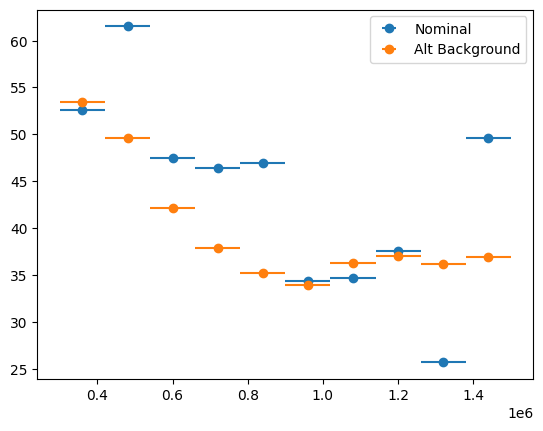

In [20]:
altbkg_hist=rejection_hist(altbkg_ys,altbkg_preds,altbkg_pts,bins,wp50_values)

fig, ax = plt.subplots()
ax.errorbar((bins[1:]+bins[:-1])/2, nom_hist, xerr=(bins[1:]-bins[:-1])/2,fmt='o',label="Nominal")
ax.errorbar((bins[1:]+bins[:-1])/2, altbkg_hist, xerr=(bins[1:]-bins[:-1])/2,fmt='o',label="Alt Background")
plt.legend()
fig.savefig(f"rejection_comparison_pt.pdf")

Let's start by loading up an alternative signal model. This one is a SM ttbar sample using a Herwig shower (as opposed to Pythia)

In [21]:
if not(os.path.isfile("ttbar_herwig_000.h5")):
    if sys.platform=="darwin": #MAC OSX
        !curl https://opendata.cern.ch/record/80030/files/assets/atlas/datascience/CERN-EP-2024-159/ttbar_herwig_000.h5.gz --output ttbar_herwig_000.h5.gz
    elif sys.platform == "linux" or sys.platform == "linux2":
        !wget https://opendata.cern.ch/record/80030/files/assets/atlas/datascience/CERN-EP-2024-159/ttbar_herwig_000.h5.gz 
    !gunzip -f ttbar_herwig_000.h5.gz

In [22]:
altsig_data=ATLASH5HighLevelDataset("ttbar_herwig_000.h5",return_pt=True)
altsig_dataloader = DataLoader(altsig_data, batch_size=2**8, shuffle=True)

altsig_preds_raw,altsig_ys,altsig_weights,altsig_pts=load_score(altsig_dataloader)
altsig_preds=decision_rule(altsig_preds_raw)

Now we usually show the signal uncertainity in a weird way so that its more comparable to the background uncertainity. We will instead find the new working point cut with the new alternative signal model, and evaluate it's performance on the nominal background sample

In [23]:
#Loop over the bins
wp50_altvalues=[]
for binx in range(Nbins):
    #Select only the jets in the pt bin
    mask = (altsig_pts>bins[binx]) & (altsig_pts<bins[binx+1])

    #Find the point where only 50% of the jets kept
    preds_in_bin=altsig_preds[mask]  
    predmin=np.min(preds_in_bin)
    predmax=np.max(preds_in_bin)
    for cut in np.linspace(predmin,predmax,1000):
        eff=(preds_in_bin>cut).sum()/len(preds_in_bin)
        if eff<0.5: break
    
    wp50_altvalues.append(eff)
    print(f"For pt bin {binx} the alt 50% decision threshold of {cut}")

    #plt.hist(preds_in_bin,bins=10,histtype="step",range=[predmin,predmax])
    #plt.yscale("log")

For pt bin 0 the alt 50% decision threshold of 2.2138038793123442
For pt bin 1 the alt 50% decision threshold of 2.061169823043753
For pt bin 2 the alt 50% decision threshold of 1.905554620128722
For pt bin 3 the alt 50% decision threshold of 1.7969530553977102
For pt bin 4 the alt 50% decision threshold of 1.6834114783908238
For pt bin 5 the alt 50% decision threshold of 1.6035677399547659
For pt bin 6 the alt 50% decision threshold of 1.5447990407054841
For pt bin 7 the alt 50% decision threshold of 1.4829179565309223
For pt bin 8 the alt 50% decision threshold of 1.4874446391937917
For pt bin 9 the alt 50% decision threshold of 1.4919664240762576


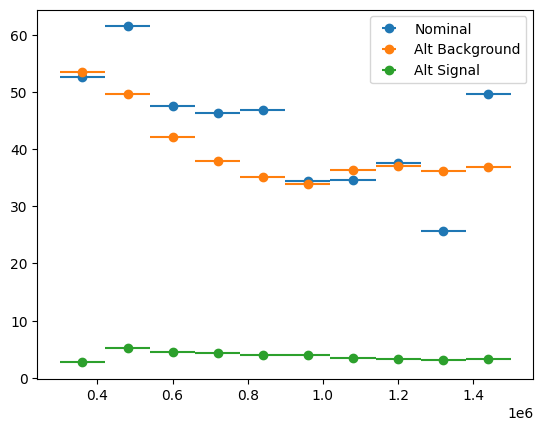

In [24]:
altsig_hist=rejection_hist(ys,preds,pts,bins,wp50_altvalues)

fig, ax = plt.subplots()
ax.errorbar((bins[1:]+bins[:-1])/2, nom_hist, xerr=(bins[1:]-bins[:-1])/2,fmt='o',label="Nominal")
ax.errorbar((bins[1:]+bins[:-1])/2, altbkg_hist, xerr=(bins[1:]-bins[:-1])/2,fmt='o',label="Alt Background")
ax.errorbar((bins[1:]+bins[:-1])/2, altsig_hist, xerr=(bins[1:]-bins[:-1])/2,fmt='o',label="Alt Signal")
plt.legend()
fig.savefig(f"rejection_comparison_pt.pdf")

You can see this one ends up being a huge effect, our tagger seems to have more difficult extrapolating across signal samples, or our fundamental uncertainity on signal modelling uncertainity is larger